In [8]:
import nibabel as nb
import numpy as np
import Functional_Fusion.atlas_map as am
import Functional_Fusion.dataset as ds
import matplotlib.pyplot as plt
import SUITPy as suit 
import nitools as nt 
import Functional_Fusion.plot as plot
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sb
from scipy import stats 
import copy 
import io
import re

base_dir = '/Volumes/diedrichsen_data$/data/FunctionalFusion' 
atlas_dir = base_dir + '/Atlases/tpl-MNI152NLin2009cSymC'



In [26]:
#these are KxP matrices for each atlas, 32 parcels 

wk_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T/atlases/cereb_cortex'


#pmap_all = np.load(f"{wk_dir}/Prob_olive.npy")


pmap_mdtb = np.load(f"{wk_dir}/Prob_cereb_grey_mdtb(ses1).npy") 
pmap_mdtb_combined = pmap_mdtb[0:16] + pmap_mdtb[16:32]


pmap_mdtb_ses2 = np.load(f"{wk_dir}/Prob_cereb_grey_mdtb(ses2).npy") 
pmap_mdtb_ses2_combined = pmap_mdtb_ses2[0:16] + pmap_mdtb_ses2[16:32]


pmap_pontine = np.load(f"{wk_dir}/Prob_cereb_grey_mdtb(high-res).npy")
pmap_pontine_combined = pmap_pontine[0:16] + pmap_pontine[16:32]


pmap_lang = np.load(f"{wk_dir}/Prob_cereb_grey_language.npy")
pmap_lang_combined = pmap_lang[0:16] + pmap_lang[16:32]


print(pmap_lang_combined.shape)

#to test the dentate results, run the next code after replacing the pmaps with dentate maps (write "dentate" wherever it says "thalamus" in the file names)


(16, 18290)


In [27]:
#repeating pearson correlation with randomization test

n_randomizations = 1000

#pmap_flat = pmap_all.flatten()

pmap_mdtb_flat = pmap_mdtb_combined.flatten()
pmap_mdtb_ses2_flat = pmap_mdtb_ses2_combined.flatten()
pmap_pontine_flat = pmap_pontine_combined.flatten()
pmap_lang_flat = pmap_lang_combined.flatten()

pairs = [
  #  ("pmap vs mdtb", pmap_flat, pmap_mdtb_flat),
  #  ("pmap vs pontine", pmap_flat, pmap_pontine_flat),
  #  ("pmap vs lang", pmap_flat, pmap_lang_flat),
    ("mdtb vs mdtb_high-res", pmap_mdtb_flat, pmap_pontine_flat),
    ("mdtb vs lang", pmap_mdtb_flat, pmap_lang_flat),
    ("mdtb_high-res vs lang", pmap_pontine_flat, pmap_lang_flat),
    ("mdtb ses1 vs ses2", pmap_mdtb_flat, pmap_mdtb_ses2_flat),
    ("mdtb_high-res vs mdtb_ses2", pmap_pontine_flat, pmap_mdtb_ses2_flat),
    ("lang vs mdtb_ses2", pmap_lang_flat, pmap_mdtb_ses2_flat),
]

# Function for shuffling all matrix rows randomly 
def shuffle_rows(matrix):
    shuffled = matrix.copy()
    np.random.shuffle(shuffled)  
    return shuffled

# Store original results
original_results = {}
for name, arr1, arr2 in pairs:
    corr, p_value = stats.pearsonr(arr1, arr2)
    original_results[name] = (corr, p_value)

# Perform randomization test
randomized_results = {name: [] for name, _, _ in pairs}

for i in range(n_randomizations):
    #print(f"Randomization {i+1}/{n_randomizations}")

    # Shuffle rows 
    pmap_mdtb_shuffled = shuffle_rows(pmap_mdtb_combined)
    pmap_mdtb_ses2_shuffled = shuffle_rows(pmap_mdtb_ses2_combined)
    pmap_pontine_shuffled = shuffle_rows(pmap_pontine_combined)
    pmap_lang_shuffled = shuffle_rows(pmap_lang_combined)

    pmap_mdtb_flat_shuffled = pmap_mdtb_shuffled.flatten()
    pmap_pontine_flat_shuffled = pmap_pontine_shuffled.flatten()
    pmap_lang_flat_shuffled = pmap_lang_shuffled.flatten()
    pmap_mdtb_ses2_flat_shuffled = pmap_mdtb_ses2_shuffled.flatten()

    # Compute correlations with shuffled data
    shuffled_pairs = [
       # ("pmap vs mdtb", pmap_flat, pmap_mdtb_flat_shuffled),
       # ("pmap vs pontine", pmap_flat, pmap_pontine_flat_shuffled),
       # ("pmap vs lang", pmap_flat, pmap_lang_flat_shuffled),

        ("mdtb vs mdtb_high-res", pmap_mdtb_flat_shuffled, pmap_pontine_flat_shuffled),
        ("mdtb vs lang", pmap_mdtb_flat_shuffled, pmap_lang_flat_shuffled),
        ("mdtb_high-res vs lang", pmap_pontine_flat_shuffled, pmap_lang_flat_shuffled),
        ("mdtb ses1 vs ses2", pmap_mdtb_flat_shuffled, pmap_mdtb_ses2_flat_shuffled),
        ("mdtb_high-res vs mdtb_ses2", pmap_pontine_flat_shuffled, pmap_mdtb_ses2_flat_shuffled),
        ("lang vs mdtb_ses2", pmap_lang_flat_shuffled, pmap_mdtb_ses2_flat_shuffled),
    ]

    for name, arr1, arr2 in shuffled_pairs:
        corr, p_value = stats.pearsonr(arr1, arr2)
        randomized_results[name].append(corr)  

print("\n=== Original vs. Randomized Correlation Results ===")

results  = []

for name in original_results.keys():
    orig_corr, orig_p = original_results[name]
    rand_corr_mean = np.mean(randomized_results[name]) #computing mean tells us what the expected correlation would be if the data was random (each random test reveals a possible correlation value on a distribution)
    rand_corr_std = np.std(randomized_results[name])

    greater_equal_count = np.sum(np.array(randomized_results[name]) >= orig_corr)
    perm_p_value = greater_equal_count / n_randomizations

    results.append({
            "Comparison (cereb cortex)": name,
            "original corr": f"{orig_corr:.4f}", 
            "randomized corr (mean ± std)": f"{rand_corr_mean:.4f} ± {rand_corr_std:.4f}", 
            "permutation-based p-value": f"{perm_p_value:.4f}"
            })
    
df = pd.DataFrame(results)
df.to_csv("correlation_results_combined_hemispheres.csv", mode = 'a', index=False)
    
  #  print(f"{name}:")
  #  print(f"  Original Corr: {orig_corr:.4f}")
  #  print(f"  Randomized Corr (mean ± std): {rand_corr_mean:.4f} ± {rand_corr_std:.4f}")
  #  print(f"  Permutation-based p-value: {perm_p_value:.4f}")
  #  print("-" * 50)



=== Original vs. Randomized Correlation Results ===


In [18]:
#KxP matrices for each atlas, 5 parcels with domains combined across hemispheres

wk_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T/atlases/rednucleus'

#pmap_all_5parcels = np.load(f"{wk_dir}/Prob_rednucleus_5parcels_hemisph_combined.npy")
pmap_mdtb_5parcels = np.load(f"{wk_dir}/Prob_rednucleus_mdtb(ses1)_5parcels_hemisph_combined.npy")  
pmap_mdtb_ses2_5parcels = np.load(f"{wk_dir}/Prob_rednucleus_mdtb(ses2)_5parcels_hemisph_combined.npy")
pmap_pontine_5parcels = np.load(f"{wk_dir}/Prob_rednucleus_mdtb(high-res)_5parcels_hemisph_combined.npy")
pmap_lang_5parcels = np.load(f"{wk_dir}/Prob_rednucleus_language_5parcels_hemisph_combined.npy")

print(pmap_mdtb_5parcels.shape)



(4, 900)


In [5]:
#KxP matrices dentate, summed across hemispheres AND collapsed to five parcels 

wk_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T/atlases/dentate'

pmap_mdtb = np.load(f"{wk_dir}/Prob_dentate_mdtb(ses1).npy") 
pmap_mdtb_combined = pmap_mdtb[0:16] + pmap_mdtb[16:32]


pmap_mdtb_ses2 = np.load(f"{wk_dir}/Prob_dentate_mdtb(ses2).npy") 
pmap_mdtb_ses2_combined = pmap_mdtb_ses2[0:16] + pmap_mdtb_ses2[16:32]


pmap_pontine = np.load(f"{wk_dir}/Prob_dentate_mdtb(high-res).npy")
pmap_pontine_combined = pmap_pontine[0:16] + pmap_pontine[16:32]


pmap_lang = np.load(f"{wk_dir}/Prob_dentate_language.npy")
pmap_lang_combined = pmap_lang[0:16] + pmap_lang[16:32]


print(pmap_lang_combined.shape)


(16, 3934)


(4, 900)


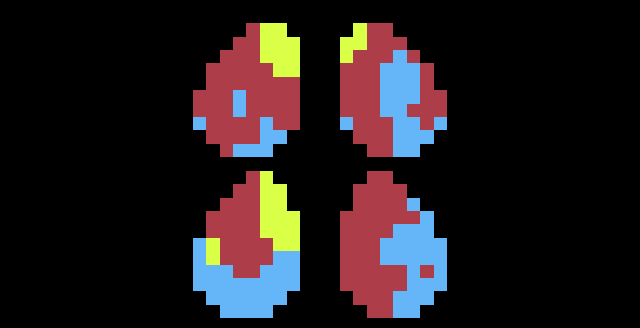

In [14]:
#collapsing 16 domain dentate atlases to 5 parcels 

wk_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T/atlases/rednucleus'

pmap = np.load(f"{wk_dir}/Prob_rednucleus_mdtb(ses2).npy")
pmap_combined = pmap[0:16] + pmap[16:32]   

lid,cmap,roi_names = nt.read_lut('/Volumes/diedrichsen_data$/data/FunctionalFusion_new/Atlases/tpl-MNI152NLin2009cSymC/atl-NettekovenSym32.lut')

new_labels = ['0','M','A','D','S'] # Use regexpress '..L','..R' for leftvs.right
index_full = ds.combine_parcel_labels(roi_names,new_labels)[1:]

index_left = index_full[0:16]
index_right = index_full[16:32]

index = index_left
new_reg = np.unique(index)

newprob = np.zeros((len(new_reg),pmap_combined.shape[1]))
for i in range(len(new_reg)):
    newprob[i,:] = pmap_combined[index==new_reg[i],:].sum(axis=0)

np.save(f"{wk_dir}/Prob_rednucleus_mdtb(ses2)_5parcels_hemisph_combined.npy", newprob)

#test = np.load(f"{wk_dir}/Prob_dentate_5parcels_hemispheres_combined.npy")

print(newprob.shape)

new_cmap = cmap[[0,3,6,8,13],:]
wta = np.argmax(newprob, axis=0) 
wta += 1
wta_int32 = wta.astype(np.int32)
dentate_parcellation = plot.plot_rednucleus(wta_int32,cscale=[0,5],cmap=new_cmap, bg_img=None)
plt.show()

In [22]:
#repeating pearson correlation with randomization test 5 parcels 

n_randomizations = 1000

#pmap_flat = pmap_all_5parcels.flatten()
pmap_mdtb_flat = pmap_mdtb_5parcels.flatten()
pmap_mdtb_ses2_flat = pmap_mdtb_ses2_5parcels.flatten()
pmap_pontine_flat = pmap_pontine_5parcels.flatten()
pmap_lang_flat = pmap_lang_5parcels.flatten()

pairs = [
   # ("pmap vs mdtb", pmap_flat, pmap_mdtb_flat),
   # ("pmap vs pontine", pmap_flat, pmap_pontine_flat),
   # ("pmap vs lang", pmap_flat, pmap_lang_flat),
    ("mdtb_ses1 vs mdtb_high_res", pmap_mdtb_flat, pmap_pontine_flat),
    ("mdtb_ses1 vs lang", pmap_mdtb_flat, pmap_lang_flat),
    ("mdtb_high_res vs lang", pmap_pontine_flat, pmap_lang_flat),
    ("mdtb_ses1 vs mdtb_ses2", pmap_mdtb_flat, pmap_mdtb_ses2_flat),
    ("mdtb_high_res vs mdtb_ses2", pmap_pontine_flat, pmap_mdtb_ses2_flat),
    ("lang vs mdtb_ses2", pmap_lang_flat, pmap_mdtb_ses2_flat),
    
]

# Function for shuffling matrix rows 
def shuffle_rows(matrix):
    shuffled = matrix.copy()
    np.random.shuffle(shuffled)  
    return shuffled

# Store original results
original_results = {}
for name, arr1, arr2 in pairs:
    corr, p_value = stats.pearsonr(arr1, arr2)
    original_results[name] = (corr, p_value)

# Perform randomization test
randomized_results = {name: [] for name, _, _ in pairs}

for i in range(n_randomizations):
    #print(f"Randomization {i+1}/{n_randomizations}")

    # Shuffle rows 
    pmap_mdtb_shuffled = shuffle_rows(pmap_mdtb_5parcels)
    pmap_pontine_shuffled = shuffle_rows(pmap_pontine_5parcels)
    pmap_lang_shuffled = shuffle_rows(pmap_lang_5parcels)
    pmap_mdtb_ses2_shuffled = shuffle_rows(pmap_mdtb_ses2_5parcels)

    pmap_mdtb_flat_shuffled = pmap_mdtb_shuffled.flatten()
    pmap_pontine_flat_shuffled = pmap_pontine_shuffled.flatten()
    pmap_lang_flat_shuffled = pmap_lang_shuffled.flatten()
    pmap_mdtb_ses2_flat_shuffled = pmap_mdtb_ses2_shuffled.flatten()

    # Compute correlations with shuffled data
    shuffled_pairs = [
        #("pmap vs mdtb", pmap_flat, pmap_mdtb_flat_shuffled),
        #("pmap vs pontine", pmap_flat, pmap_pontine_flat_shuffled),
        #("pmap vs lang", pmap_flat, pmap_lang_flat_shuffled),
        ("mdtb vs pontine", pmap_mdtb_flat_shuffled, pmap_pontine_flat_shuffled),
        ("mdtb vs lang", pmap_mdtb_flat_shuffled, pmap_lang_flat_shuffled),
        ("pontine vs lang", pmap_pontine_flat_shuffled, pmap_lang_flat_shuffled),
        ("mdtb ses1 vs ses2", pmap_mdtb_flat_shuffled, pmap_mdtb_ses2_flat_shuffled),
        ("pontine vs mdtb_ses2", pmap_pontine_flat_shuffled, pmap_mdtb_ses2_flat_shuffled),
        ("lang vs mdtb_ses2", pmap_lang_flat_shuffled, pmap_mdtb_ses2_flat_shuffled),
    ]

    for name, arr1, arr2 in shuffled_pairs:
        corr, p_value = stats.pearsonr(arr1, arr2)
        randomized_results[name].append(corr)  

print("\n=== Original vs. Randomized Correlation Results ===")

results  = []

for name in original_results.keys():
    orig_corr, orig_p = original_results[name]
    rand_corr_mean = np.mean(randomized_results[name]) #computing mean tells us what the expected correlation would be if the data was random (each random test reveals a possible correlation value on a distribution)
    rand_corr_std = np.std(randomized_results[name])
    greater_equal_count = np.sum(np.array(randomized_results[name]) >= orig_corr)
    perm_p_value = greater_equal_count / n_randomizations

    results.append({
            "Comparison (red nucleus 4 parcels)": name,
            "original corr": f"{orig_corr:.4f}", 
            "randomized corr (mean ± std)": f"{rand_corr_mean:.4f} ± {rand_corr_std:.4f}", 
            "permutation-based p-value":  f"{perm_p_value:.4f}"
            })
    
    
df = pd.DataFrame(results)
df.to_csv("correlation_results_combined_hemispheres.csv", mode = 'a', index=False)

    #print(f"{name}:")
    #print(f"  Original Corr: {orig_corr:.4f}")
    #print(f"  Randomized Corr (mean ± std): {rand_corr_mean:.4f} ± {rand_corr_std:.4f}")
    #print(f"  Permutation-based p-value: {perm_p_value:.4f}")
    #print("-" * 50)



=== Original vs. Randomized Correlation Results ===


In [19]:
#repeating pearson correlation with randomization test 4 parcels 

from scipy import stats
import itertools

# Define matrix pairs
pairs = [
    ("mdtb_ses1 vs mdtb_high_res", pmap_mdtb_5parcels, pmap_pontine_5parcels),
    ("mdtb_ses1 vs lang", pmap_mdtb_5parcels, pmap_lang_5parcels),
    ("mdtb_high_res vs lang", pmap_pontine_5parcels, pmap_lang_5parcels),
    ("mdtb_ses1 vs mdtb_ses2", pmap_mdtb_5parcels, pmap_mdtb_ses2_5parcels),
    ("mdtb_high_res vs mdtb_ses2", pmap_pontine_5parcels, pmap_mdtb_ses2_5parcels),
    ("lang vs mdtb_ses2", pmap_lang_5parcels, pmap_mdtb_ses2_5parcels),
]

# Generate all 4! = 24 row permutations
row_perms = list(itertools.permutations(range(4)))

results = []

for name, arr1, arr2 in pairs:
    arr1_flat = arr1.flatten()
    arr2_flat = arr2.flatten()
    
    # Original correlation
    orig_corr, _ = stats.pearsonr(arr1_flat, arr2_flat)

    # Null distribution: permute rows of arr1
    perm_corrs = []
    for perm in row_perms:
        shuffled_arr1 = arr1[list(perm), :]
        shuffled_flat = shuffled_arr1.flatten()
        corr, _ = stats.pearsonr(shuffled_flat, arr2_flat)
        perm_corrs.append(corr)

    perm_corrs = np.array(perm_corrs)
    # One-sided test: how many permuted corr ≥ original corr?
    perm_p = np.sum(perm_corrs >= orig_corr) / len(perm_corrs)

    results.append({
        "Comparison (dentate, 4 parcels)": name,
        "Original correlation": f"{orig_corr:.4f}",
        "Null (perm mean ± std)": f"{perm_corrs.mean():.4f} ± {perm_corrs.std():.4f}",
        "Exact permutation p-value": f"{perm_p:.4f}"
    })
    
df = pd.DataFrame(results)
df.to_csv("correlation_results_combined_hemispheres.csv", mode = 'a', index=False)



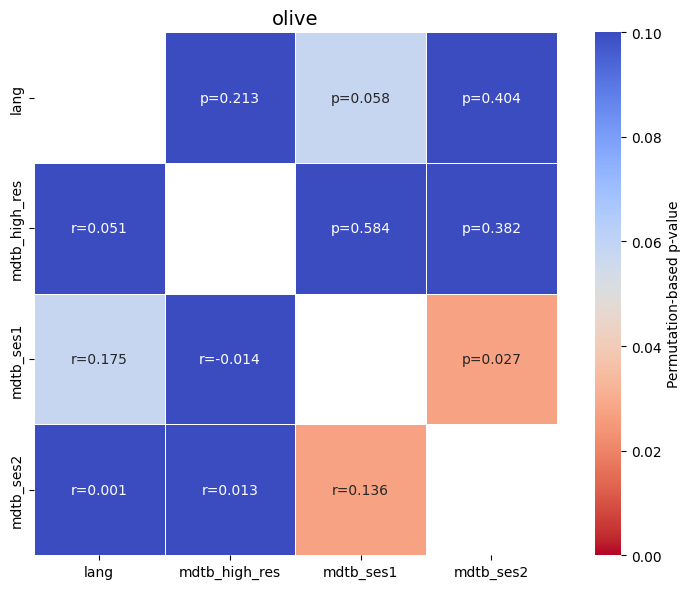

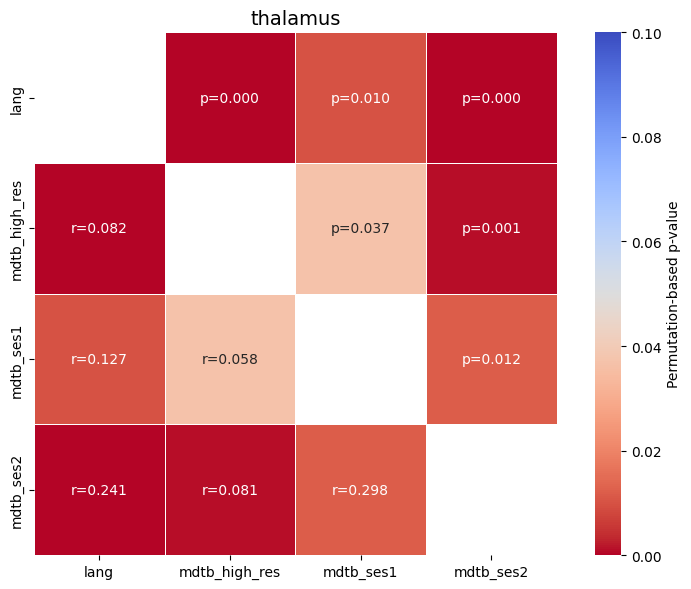

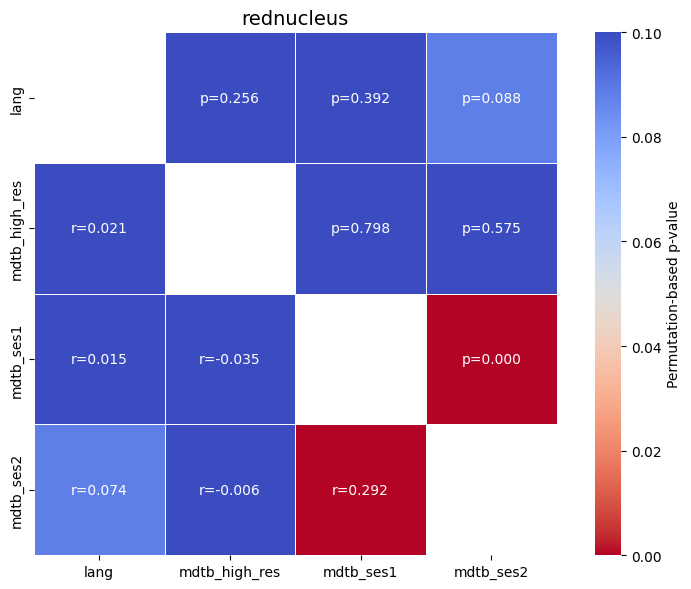

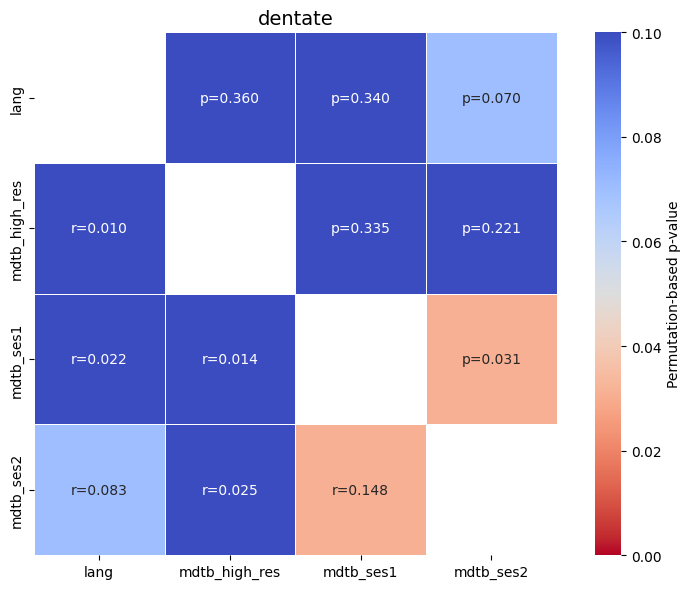

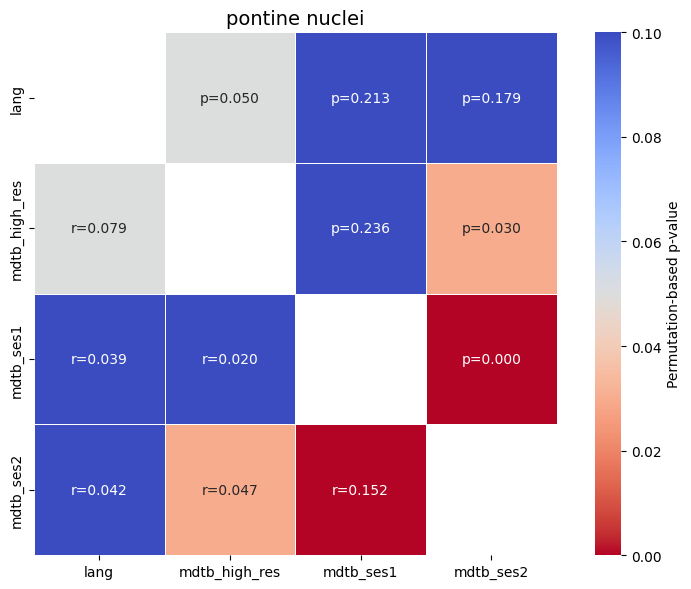

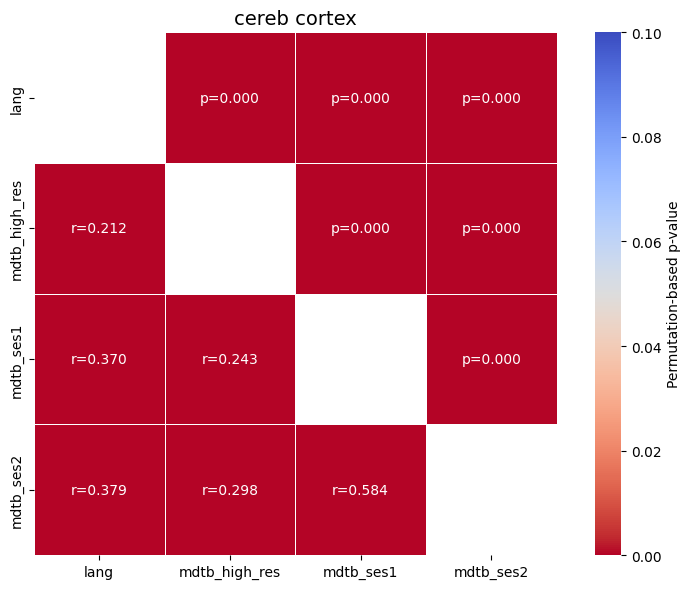

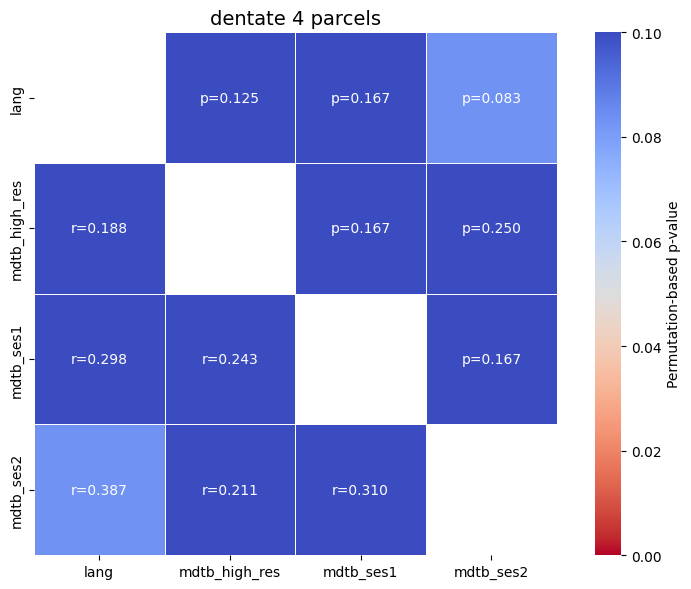

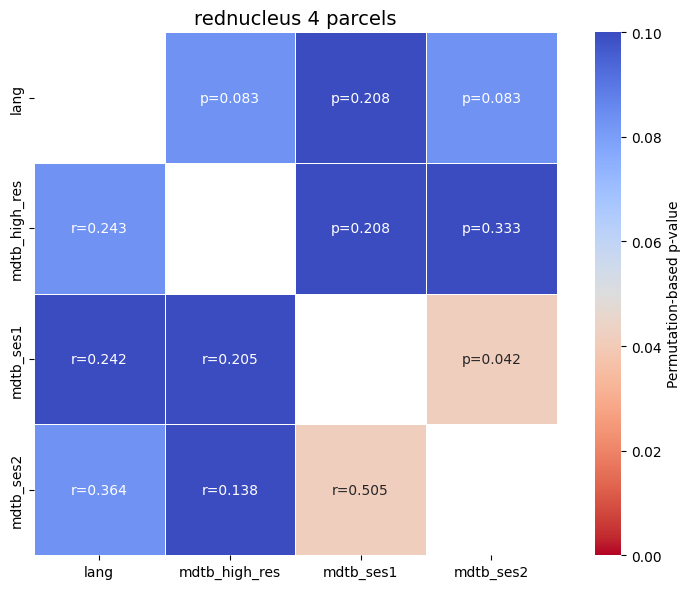

In [21]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import re
import io

# --- Step 1: Read in the entire raw CSV as text ---
with open("correlation_results_combined_hemispheres.csv", "r") as file:
    raw_text = file.read()

# --- Step 2: Split into ROI blocks using regex ---
blocks = re.split(r'\n(?=Comparison \()', raw_text)

roi_dataframes = {}

for block in blocks:
    lines = block.strip().split('\n')
    if not lines or len(lines) < 2:
        continue
    
    match = re.match(r'Comparison \((.+?)\)', lines[0])
    if match:
        roi_name = match.group(1).strip()
        csv_text = "\n".join(lines)
        df = pd.read_csv(io.StringIO(csv_text))
        roi_dataframes[roi_name] = df

# --- Step 3: Loop over each ROI and generate heatmap ---
for selected_roi, df in roi_dataframes.items():
    # Parse comparison names
    df["dataset1"] = df[df.columns[0]].str.extract(r'(\w+(?:[_\s]\w+)*) vs')[0]
    df["dataset2"] = df[df.columns[0]].str.extract(r'vs (\w+(?:[_\s]\w+)*)')[0]

    datasets = sorted(set(df["dataset1"].dropna()) | set(df["dataset2"].dropna()))


    #datasets = sorted(set(df["dataset1"]).union(df["dataset2"]))

    pval_matrix = pd.DataFrame(index=datasets, columns=datasets, dtype=float)
    annot_matrix = pd.DataFrame(index=datasets, columns=datasets, dtype=str)

    for _, row in df.iterrows():
        d1 = row["dataset1"]
        d2 = row["dataset2"]
        corr = float(row["original corr"])
        pval = float(row["permutation-based p-value"])
        text = f"r={corr:.3f}\n(p={pval:.3f})"
        
        pval_matrix.loc[d1, d2] = pval
        pval_matrix.loc[d2, d1] = pval

        if d1 != d2:
            if datasets.index(d1) < datasets.index(d2):
                annot_matrix.loc[d1, d2] = f"p={pval:.3f}"
                annot_matrix.loc[d2, d1] = f"r={corr:.3f}"
            else:
                annot_matrix.loc[d1, d2] = f"r={corr:.3f}"
                annot_matrix.loc[d2, d1] = f"p={pval:.3f}"

    for d in datasets:
        pval_matrix.loc[d, d] = None
        annot_matrix.loc[d, d] = "--"
        #annot_matrix.loc[d, d] = "1.00\n(p=—)"

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sb.heatmap(
        pval_matrix,
        annot=annot_matrix,
        fmt="",
        cmap="coolwarm_r",  # red = more significant
        vmin=0, vmax=0.1,
        square=True,
        linewidths=0.5,
        cbar_kws={"label": "Permutation-based p-value"}
    )
    plt.title(f"{selected_roi}", fontsize=14)
    plt.tight_layout()
    plt.show()
